# Analysis of Handwritten Words

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

import keras

%matplotlib inline

Using TensorFlow backend.


## Get image path

In [40]:
# dictionary of filename : [path, word]
images = {}

for root,dirs,files in os.walk("./data"):
    if not dirs:
        for file in files:
            filename = os.path.join(root, file)
            images[file] = [filename , ""]

## Get mapping
Actual word associated with the image

In [52]:
with open("./words.txt") as f:
    lines = f.read().split("\n")
    
    #first 18 lines are description
    for line in lines[18:-1]:
        elements = line.split(" ")
        name = str(elements[0]) + ".png"
        images[name][1] = elements[-1]

## Display random image from set

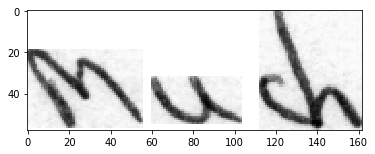

In [93]:
rand = np.random.choice(len(images))
randomImage = list(images)[rand]

img = mpimg.imread(images[randomImage][0])
plt.imshow(img, cmap="gray")

In [94]:
myword = images[randomImage][1]
myword

'much'

## Characteristics of image

In [95]:
list(images.items())[rand]

('g04-092-00-07.png', ['./data/g04/g04-092/g04-092-00-07.png', 'much'])

In [96]:
data = np.asarray( img, dtype="float32" )
d = data.shape

In [97]:
d

(58, 162)

In [70]:
data

array([[ 0.89411765,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.89411765,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 0.67843139,  0.29803923,  0.24705882, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.75294119,  0.39215687,  0.3882353 , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.87058824,  0.75294119,  0.60000002, ...,  1.        ,
         1.        ,  1.        ]], dtype=float32)

In [98]:
wordlist = []
for w in list(images.items()):
    wordlist.append(w[1][1])
wordlist = list(set(wordlist))

wordlist.index(myword)

7931

In [100]:
wordlist[wordlist.index(myword)]

'much'

In [227]:
class Words():
    
    wordCount = 0
    maxSize = [0, 0]
    
    def __init__(self, name, path, word, wordIndex, size, data):
            self.name = name
            self.path = path
            self.word = word
            self.wordIndex = wordIndex
            self.original_size = size
            self.size = list(size)
            self.data = data
            
            Words.wordCount += 1
            
            if self.size[0] > Words.maxSize[0]:
                Words.maxSize[0] = self.size[0]
            if self.size[1] > Words.maxSize[1]:
                Words.maxSize[1] = self.size[1]


    def resize(self, new_size=maxSize):
        
        noOfCols =  new_size[1] - self.size[1]
        #Adding cols at the beginning 
        self.data = np.c_[ np.ones( (self.size[0],noOfCols//2) ), self.data ]
        #Adding remaining cols at the end
        self.data = np.c_[ self.data, np.ones( (self.size[0], noOfCols - noOfCols//2) ) ]
        self.size[1] = new_size[1]
        
        noOfRows = new_size[0] - self.size[0]
        #Adding rows at the beginning 
        self.data = np.r_[ np.ones( (noOfRows//2, self.size[1]) ), self.data ]
        #Adding remaining rows at the end
        self.data = np.r_[ self.data, np.ones( (noOfRows - noOfRows//2, self.size[1]) ) ]
        self.size[0] = new_size[0]

In [228]:
myWord = Words(name = "g04-092-00-07.png", 
               path="./data/g04/g04-092/", 
               word="much", wordIndex=7931, size=data.shape, data=data)

In [229]:
myWord.size

[58, 162]

In [230]:
myWord.resize([60,170])

In [231]:
myWord.size

[60, 170]

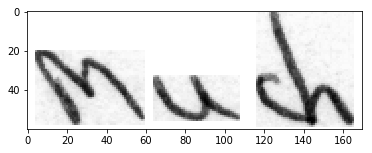

In [232]:
plt.imshow(myWord.data, cmap="gray")
plt.show()